In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

In [10]:
b_size = 5
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip = True,
                                  #수평 대칭 이미지를 50% 확률로 만듦
                                  width_shift_range=0.1,
                                  #전체 크기의 10% 범위에서 좌우로 이동
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

In [11]:
train_generator = train_datagen.flow_from_directory(
                            'train',
                            target_size=(150,150),
                            batch_size=b_size,
                            class_mode='binary')

Found 160 images belonging to 2 classes.


In [12]:
b_size = 5
test_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip = True,
                                  #수평 대칭 이미지를 50% 확률로 만듦
                                  width_shift_range=0.1,
                                  #전체 크기의 10% 범위에서 좌우로 이동
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

In [13]:
test = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                            'test',
                            target_size=(150,150),
                            batch_size=b_size,
                            class_mode='binary')

Found 120 images belonging to 2 classes.


In [14]:
transfer_model = VGG16(weights='imagenet', include_top = False,input_shape=(150, 150, 3)) # include_top: 위에 Dense 층을 뺀다. 풀리 컨티넥트를  뺐다, 
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [15]:
finetune_model = Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/20
32/32 [==============================] - 16s 486ms/step - loss: 0.6547 - accuracy: 0.6250 - val_loss: 0.4375 - val_accuracy: 0.8667
Epoch 2/20
32/32 [==============================] - 15s 480ms/step - loss: 0.4006 - accuracy: 0.8250 - val_loss: 0.3923 - val_accuracy: 0.8500
Epoch 3/20
32/32 [==============================] - 15s 465ms/step - loss: 0.2711 - accuracy: 0.9125 - val_loss: 0.2716 - val_accuracy: 0.9167
Epoch 4/20
32/32 [==============================] - 15s 460ms/step - loss: 0.2182 - accuracy: 0.9375 - val_loss: 0.2299 - val_accuracy: 0.9333
Epoch 5/20
32/32 [==============================] - 16s 514ms/step - loss: 0.1996 - accuracy: 0.9125 - val_loss: 0.2473 - val_accuracy: 0.9000
Epoch 6/20
32/32 [==============================] - 15s 473ms/step - loss: 0.1420 - accuracy: 0.9750 - val_loss: 0.2515 - val_accuracy: 0.9000
Epoch 7/20
32/32 [==============================] - 15s 467ms/step - loss: 0.1588 - accuracy: 0.9250 - val_loss: 0.1549 - val_accuracy: 0.9583

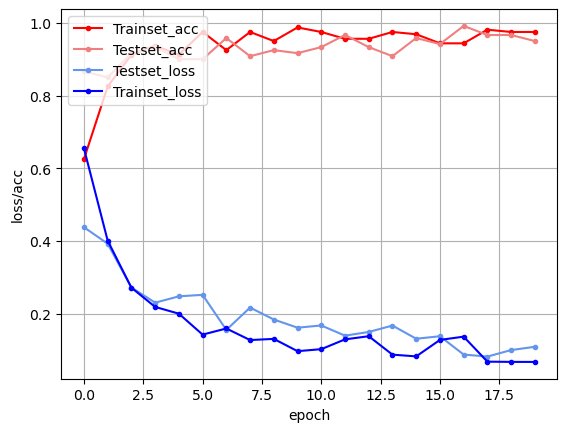

In [16]:
finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

steps_train = len(train_generator)
steps_test = len(test_generator)

history = finetune_model.fit(
       train_generator,
       steps_per_epoch=steps_train, # 수치가 맞지 않으면 삐그덕 거리기 때문에 이런 식으로 맞춰준 것이다.
       epochs=20,
       validation_data=test_generator,
       validation_steps=steps_test )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len,val_acc, marker='.', c='lightcoral', label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
 
plt.legend(loc='upper left') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()